In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
label="Outcome"

In [3]:
path_file= "final_diabetes_dataset.csv"
df=pd.read_csv(path_file)

In [4]:
print(df.head())

   Pregnancies  Glucose   BMI  DiabetesPedigreeFunction  Outcome
0            1       97  38.1                     0.218        0
1            5       78  33.7                     0.654        0
2            3      111  29.5                     0.430        0
3            2      129  28.0                     0.284        0
4            7      102  37.2                     0.204        0


In [5]:
def rescalerZFeatureMap(df):
    scaler=MinMaxScaler(feature_range=(0,np.pi))
    columns_to_scale = df.columns.difference([label])
    df_scaled_part = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=columns_to_scale)
    df_scaled = pd.concat([df_scaled_part, df[label]], axis=1)
    df_scaled = df_scaled[df.columns]
    return df_scaled

def rescalerZZFeatureMap(df):
    scaler=MinMaxScaler(feature_range=(0, 1))  # step 1: normalizza in [0,1]
    X_scaled = scaler.fit_transform(df)
    return X_scaled * np.pi

In [6]:
#df=rescalerZZFeatureMap(df)
df=rescalerZFeatureMap(df)

In [7]:
X = df.drop(label, axis=1)
y = df[label]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train_new=X_train.values.tolist()
X_test_new=X_test.values.tolist()
y_train_new=y_train.tolist()
y_test_new=y_test.tolist()

# Quantum Variational Classifier

### Circuito per Encoding

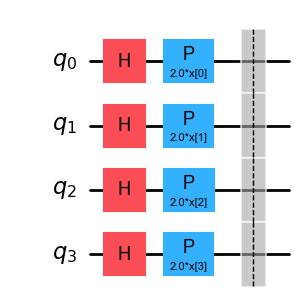

In [10]:
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap

num_features = df.shape[1]-1

#feature_map = PauliFeatureMap(feature_dimension=num_features, reps=1)
#feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map = ZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.barrier()
feature_map.decompose().draw(output="mpl", fold=20)

### Quantum Circuit Ansatz

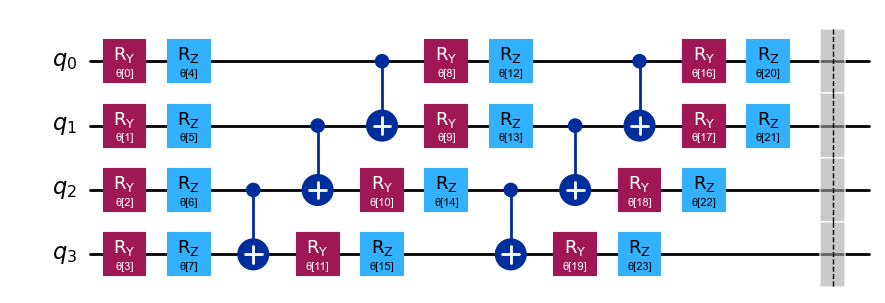

In [21]:
from qiskit.circuit.library import EfficientSU2

ansatz=EfficientSU2(num_features,reps=2)
ansatz.barrier()
ansatz.decompose().draw(output="mpl", fold=20)

## Combiniamo il tutto ed eseguiamo l'algoritmo Variational Quantum Classifier

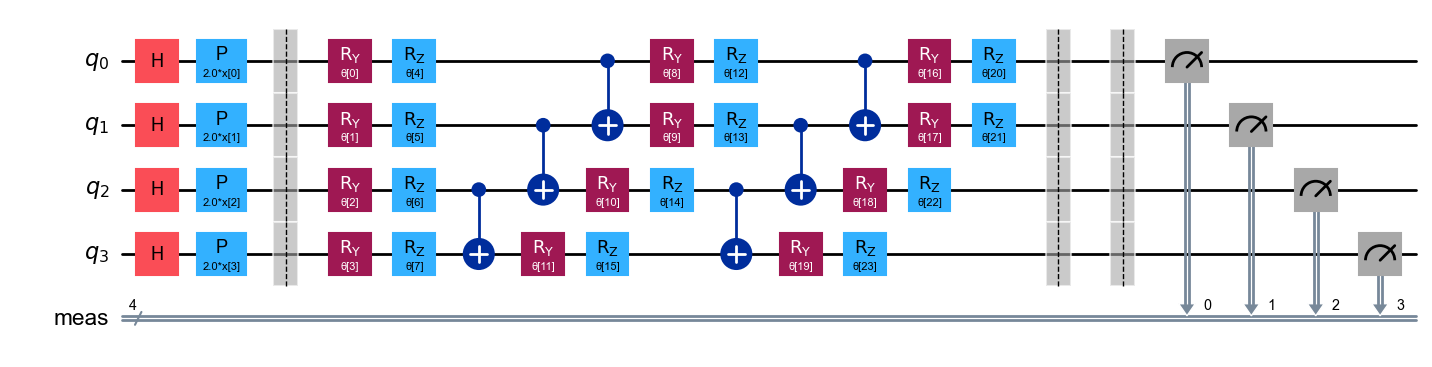

In [22]:
ad_hoc_circuit = feature_map.compose(ansatz)
ad_hoc_circuit.measure_all()
ad_hoc_circuit.decompose().draw(output="mpl", style="iqp")

### Funzioni di utilità per minimizzare la loss function

In [23]:
from matplotlib import pyplot as plt

In [24]:

from collections import Counter
#log_loss equivalente a cross-entropy
from sklearn.metrics import log_loss, accuracy_score
from qiskit.primitives import StatevectorSampler


def circuit_instance(tuple, variational):
    # tuple: una tupla
    # variational: parametri dell'ansatz (theta)
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] =tuple[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = variational[i]
    return ad_hoc_circuit.assign_parameters(parameters)


def interpreter(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight) % 2

def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    #probabilities = {0: 0, 1: 0, 2: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities

def classification_probability(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    return classification

def compute_class_weights(labels):
    counts = Counter(labels)
    total = len(labels)
    num_classes = len(counts)
    weights = {cls: total / (num_classes * count) for cls, count in counts.items()}
    return weights

def weighted_cross_entropy_loss(classification, expected, class_weights):
    """Cross entropy pesata per una singola predizione."""
    p = classification.get(expected, 1e-10)  # Probabilità classe corretta
    weight = class_weights.get(expected, 1)
    return float(-weight * np.log(p + 1e-10))

def cost_function(data, labels, variational):
    """Cross-entropy loss media ponderata sulle classi."""

    #esegue il circuito e restituisce una lista contenente un dizionario (uno per ogni tupla) contentente le probabilità assegnate per ogni classe
    # es: {0:0.4, 1:0.6}
    classifications = classification_probability(data, variational)

    # calcola il peso associato ad ogni classe
    class_weights = compute_class_weights(labels)

    #CALCOLO FUNZIONE DI COSTO
    cost = 0
    for i, classification in enumerate(classifications):
        #Cross entropy pesata per una singola predizione
        cost += weighted_cross_entropy_loss(classification, labels[i], class_weights)

    return cost / len(data)

def cost_function2(data, labels, variational):

    classifications = classification_probability(data, variational)
    cost=log_loss(y_true=labels,y_pred=[[p[0],p[1]] for p in classifications])
    return cost

def objective_function(variational):
    return cost_function(X_train_new, y_train_new, variational)

In [25]:
from scipy.optimize import minimize


class OptimizerLog:
    """Log per salvare i risultati intermedi dell'ottimizzazione."""
    def __init__(self):
        self.evaluations = 0
        self.parameters = []
        self.costs = []

    def callback(self, xk):
        """Funzione di callback compatibile con scipy.optimize.minimize."""
        cost = objective_function(xk)
        self.parameters.append(xk.copy())
        print("loss_function:", cost, "iterazione:", self.evaluations)
        self.costs.append(cost)
        self.evaluations += 1

# Istanzia il logger
logger = OptimizerLog()

# Punto iniziale (supponiamo che ansatz.num_parameters sia definito)
initial_point = np.zeros((ansatz.num_parameters))
#initial_point = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)

# Esegui l'ottimizzazione
res = minimize(
    objective_function,
    initial_point,
    method="COBYLA",
    options={"maxiter": 5000, "disp": True},
    callback=logger.callback
)
# Accesso ai risultati intermedi
print("Parametri valutati:", logger.parameters)
print("Costi corrispondenti:", logger.costs)

loss_function: 0.6939253318907425 iterazione: 0
loss_function: 0.6941360366743293 iterazione: 1
loss_function: 0.6962183637603688 iterazione: 2
loss_function: 0.6878605916298028 iterazione: 3
loss_function: 0.6937570765612975 iterazione: 4
loss_function: 0.6915547435242592 iterazione: 5
loss_function: 0.6980775510005912 iterazione: 6
loss_function: 0.690497064016034 iterazione: 7
loss_function: 0.6948104233518652 iterazione: 8
loss_function: 0.6892137509082924 iterazione: 9
loss_function: 0.6921798671555426 iterazione: 10
loss_function: 1.09650194165474 iterazione: 11
loss_function: 0.6923983659764767 iterazione: 12
loss_function: 0.6915014364092359 iterazione: 13
loss_function: 0.6918907915786114 iterazione: 14
loss_function: 0.6956193505764222 iterazione: 15
loss_function: 0.694837092741226 iterazione: 16
loss_function: 0.6944480978185089 iterazione: 17
loss_function: 0.6966461828921731 iterazione: 18
loss_function: 0.6955155395293241 iterazione: 19
loss_function: 0.6921706867141137 

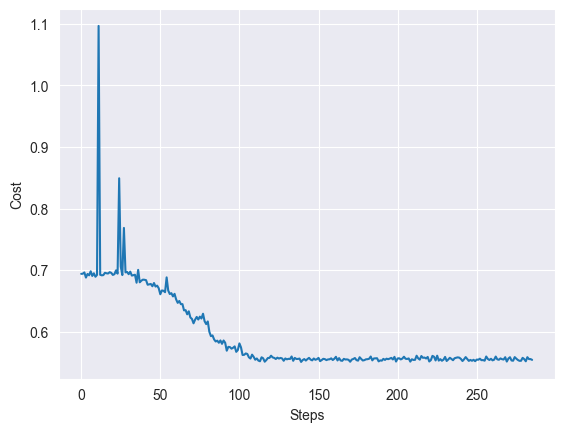

migliori parametri [ 1.36337499 -0.2055909  -0.61572689  0.57975899 -0.45788636  1.5572425
  0.40167547  0.15574631  0.4290664   0.52463001 -0.14027883 -0.25705553
 -0.02986744 -0.3119278  -0.46257574 -0.60801311 -0.08152167  0.76654463
  0.80943124 -0.07580656  0.06250037 -0.45494859  0.03713831 -0.46923803]
miglior funzione obiettivo 0.5547576010629048


In [26]:
opt_var = res.x # migliori parametri della funzione obiettivo e quindi dell'ansatz
opt_value = res.fun # ultima valutazione della funzione obiettivo, nel nostro caso cross-entropy (log_loss)

fig = plt.figure()
plt.plot(logger.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print("migliori parametri",opt_var)
print("miglior funzione obiettivo",opt_value)

In [27]:
def test_classifier(data, labels, variational):
    probability = classification_probability(data, variational)
    #print(probability)
    predictions= [max(p, key=p.get) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy_train, predictions_train = test_classifier(X_train_new, y_train_new, opt_var)
accuracy_test, predictions_test = test_classifier(X_test_new, y_test_new, opt_var)
print(accuracy_train,accuracy_test)

0.7285714285714285 0.7666666666666667


In [28]:
accuracy_train=accuracy_score(y_train_new,predictions_train)
accuracy_test=accuracy_score(y_test_new,predictions_test)
print(accuracy_train)
print(accuracy_test)

0.7285714285714285
0.7666666666666667


In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_new,predictions_test)

array([[24,  7],
       [ 7, 22]])

In [30]:
confusion_matrix(y_train_new,predictions_train)

array([[53, 16],
       [22, 49]])